# Flood forecasting project — Hanoi (Synthetic dataset)
This notebook contains:
1. Loading and preprocessing of time series rainfall data
2. Feature engineering for time series data
3. XGBoost training and evaluation with TimeSeriesSplit
4. Model saving and inference examples

## Dataset Information
- **Training Data**: `data/FloodModeling2_TRAIN.ts` - Contains 559 hourly rainfall events time series
- **Test Data**: `data/FloodModeling2_TEST.ts` - Test dataset for model evaluation
- **Data Format**: Time series data with rainfall values and target water depth labels
- **Data Source**: Synthetic data generated by Monash University researchers

## Key Features
- Time series feature engineering (statistical, lag, rolling windows, EWMA)
- XGBoost classifier with proper time series cross-validation
- Feature scaling and comprehensive evaluation metrics
- Model persistence with scaler for inference


## Data Loading and Preprocessing
The notebook loads time series data from `.ts` format files where:
- Each line represents a complete rainfall time series
- Values are comma-separated rainfall measurements
- Target water depth is indicated after a colon (`:`)
- Data is automatically parsed and converted to pandas DataFrames

## Feature Engineering
The notebook creates comprehensive features from time series data:
- **Statistical features**: mean, max, min, std, sum
- **Lag features**: rainfall values at different time lags (1, 3, 6, 12, 24 hours)
- **Rolling window features**: sum and mean over different windows (3, 6, 24 hours)
- **EWMA features**: Exponential weighted moving average (API-like)
- **Peak detection**: Count of peaks above threshold
- **Trend features**: Linear trend slope


In [4]:
import pandas as pd
import numpy as np

# Load synthetic time series data
def load_ts_data(file_path):
    """Load time series data from .ts format"""
    data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Skip header lines (lines starting with @ or #)
    data_lines = [line.strip() for line in lines if not line.startswith('@') and not line.startswith('#') and line.strip()]
    
    for line in data_lines:
        if ':' in line:
            # Split time series and target
            ts_part, target = line.split(':')
            # Convert time series to float array
            ts_values = [float(x) for x in ts_part.split(',')]
            # Add target as label
            data.append(ts_values + [float(target)])
    
    return np.array(data)

# Load training and test data
train_data = load_ts_data('../data/FloodModeling2_TRAIN.ts')
test_data = load_ts_data('../data/FloodModeling2_TEST.ts')

print(f'Training data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')
print(f'Number of time series: {train_data.shape[0]}')
print(f'Time series length: {train_data.shape[1] - 1}')  # -1 for target column

# Create DataFrame for easier handling
# Each row represents one time series, columns are time steps + target
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

# Rename columns
time_cols = [f't_{i}' for i in range(train_data.shape[1] - 1)]
df_train.columns = time_cols + ['target']
df_test.columns = time_cols + ['target']

print('\nTraining data sample:')
print(df_train.head())
print(f'\nTarget distribution (training): {df_train["target"].value_counts().to_dict()}')

Training data shape: (466, 267)
Test data shape: (201, 267)
Number of time series: 466
Time series length: 266

Training data sample:
         t_0       t_1       t_2       t_3       t_4       t_5       t_6  \
0   0.671341  0.000000  0.000000  0.000000  0.607188  0.000000  0.000000   
1  10.358937  8.840564  6.669556  4.215084  1.874046  0.000000  0.000000   
2   0.405166  2.020911  0.129414  0.000000  0.090412  0.000000  0.089203   
3   1.571706  0.494502  0.133301  0.892255  0.000000  0.028056  0.258618   
4  14.946884  1.768384  6.954739  0.000000  2.923030  2.886370  8.878232   

       t_7       t_8       t_9  ...  t_257  t_258  t_259  t_260  t_261  t_262  \
0  0.00699  0.358388  0.000000  ...    0.0    0.0    0.0    0.0    0.0    0.0   
1  0.00000  0.000000  0.000000  ...    0.0    0.0    0.0    0.0    0.0    0.0   
2  0.00000  0.230633  0.279402  ...    0.0    0.0    0.0    0.0    0.0    0.0   
3  0.00000  0.220481  0.183596  ...    0.0    0.0    0.0    0.0    0.0    0.0   
4  0

🧩 Data Overview:
Rows (events): 466
Time steps per event: 266
Target column: target
Unique target values: 27

     count      mean       std           min       25%       50%       75%  \
t_0  466.0  1.745607  7.011176  2.362587e-16  0.189714  0.495988  1.306386   
t_1  466.0  1.111517  2.261347  0.000000e+00  0.000000  0.372642  1.162909   
t_2  466.0  1.119039  2.279012  0.000000e+00  0.000000  0.349941  1.240427   
t_3  466.0  0.941218  1.753256  0.000000e+00  0.000000  0.364678  1.061823   
t_4  466.0  0.946934  1.997299  0.000000e+00  0.000000  0.304803  1.052450   

            max  
t_0  138.591361  
t_1   28.674250  
t_2   30.754209  
t_3   25.242941  
t_4   28.107169  


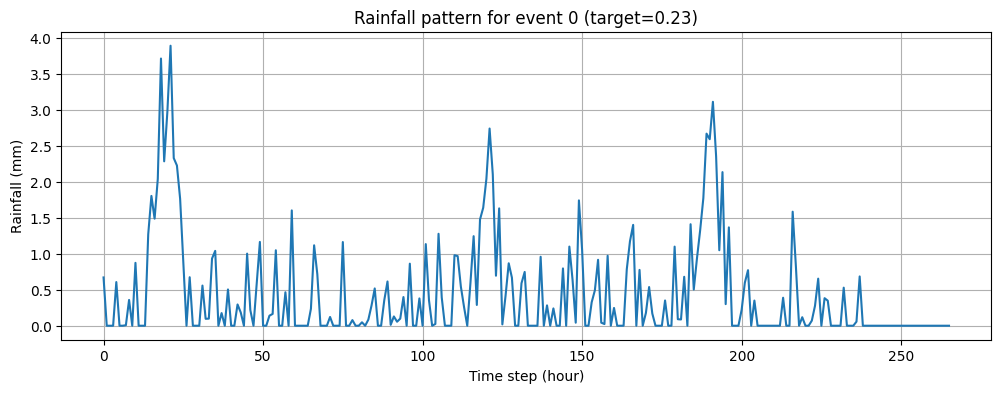

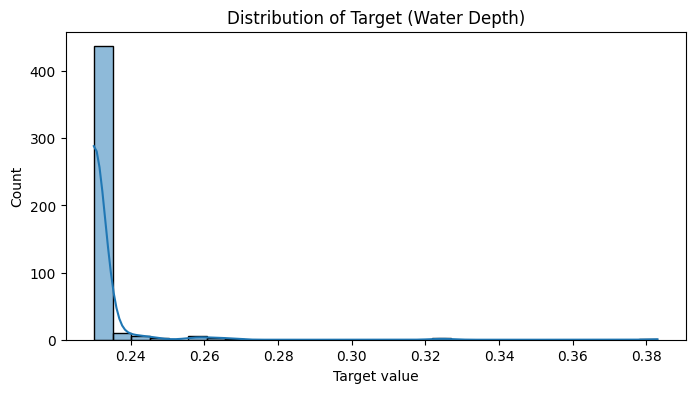

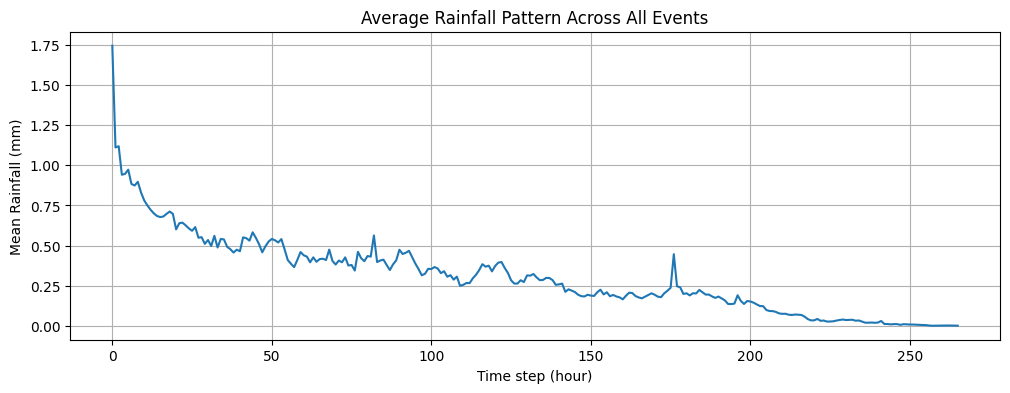


💧 Top 10 Most Variable Time Steps (hours with biggest rainfall changes):
t_0      7.011176
t_176    4.404612
t_82     3.353900
t_2      2.279012
t_1      2.261347
t_5      2.205196
t_4      1.997299
t_3      1.753256
t_8      1.701759
t_6      1.663873
dtype: float64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- BASIC INSPECTION ---
print("🧩 Data Overview:")
print(f"Rows (events): {df_train.shape[0]}")
print(f"Time steps per event: {df_train.shape[1] - 1}")
print(f"Target column: {df_train.columns[-1]}")
print(f"Unique target values: {df_train['target'].nunique()}\n")

# Check a few statistics about rainfall per time step
desc = df_train.drop(columns=['target']).describe().T
print(desc.head())

# --- PLOT SAMPLE EVENT (RAIN PATTERN) ---
sample_idx = 0  # pick the first event
series = df_train.iloc[sample_idx, :-1]  # exclude target
plt.figure(figsize=(12, 4))
plt.plot(range(len(series)), series.values)
plt.title(f"Rainfall pattern for event {sample_idx} (target={df_train.loc[sample_idx, 'target']})")
plt.xlabel("Time step (hour)")
plt.ylabel("Rainfall (mm)")
plt.grid(True)
plt.show()

# --- DISTRIBUTION OF TARGETS ---
plt.figure(figsize=(8, 4))
sns.histplot(df_train['target'], bins=30, kde=True)
plt.title("Distribution of Target (Water Depth)")
plt.xlabel("Target value")
plt.ylabel("Count")
plt.show()

# --- CHECK AVERAGE RAINFALL PROFILE ACROSS ALL EVENTS ---
mean_rain = df_train.drop(columns=['target']).mean()
plt.figure(figsize=(12, 4))
plt.plot(mean_rain.values)
plt.title("Average Rainfall Pattern Across All Events")
plt.xlabel("Time step (hour)")
plt.ylabel("Mean Rainfall (mm)")
plt.grid(True)
plt.show()

# --- OPTIONAL: VIEW TIME STEPS WITH HIGHEST RAINFALL VARIABILITY ---
std_rain = df_train.drop(columns=['target']).std()
top_var_steps = std_rain.sort_values(ascending=False).head(10)
print("\n💧 Top 10 Most Variable Time Steps (hours with biggest rainfall changes):")
print(top_var_steps)

## Feature Engineering for Time Series Data
This section creates comprehensive features from the rainfall time series data to improve model performance. The features capture different aspects of the rainfall patterns that are relevant for flood prediction.

In [6]:
# Feature engineering for time series data
def create_time_series_features(df, time_cols):
    """Create features from time series data"""
    features_df = df.copy()
    
    # Convert time series to numpy array for easier manipulation
    ts_data = df[time_cols].values
    
    # 1. Statistical features
    features_df['mean_rainfall'] = ts_data.mean(axis=1)
    features_df['max_rainfall'] = ts_data.max(axis=1)
    features_df['min_rainfall'] = ts_data.min(axis=1)
    features_df['std_rainfall'] = ts_data.std(axis=1)
    features_df['sum_rainfall'] = ts_data.sum(axis=1)
    
    # 2. Lag features (using different time windows)
    for lag in [1, 3, 6, 12, 24]:
        if lag < ts_data.shape[1]:
            features_df[f'rain_lag_{lag}'] = ts_data[:, -lag-1]  # Last lag values
    
    # 3. Rolling window features
    for window in [3, 6, 24]:
        if window <= ts_data.shape[1]:
            # Rolling sum
            rolling_sums = []
            for i in range(ts_data.shape[0]):
                if i >= window - 1:
                    rolling_sums.append(ts_data[i, -window:].sum())
                else:
                    rolling_sums.append(ts_data[i, :i+1].sum())
            features_df[f'rain_sum_{window}h'] = rolling_sums
            
            # Rolling mean
            rolling_means = []
            for i in range(ts_data.shape[0]):
                if i >= window - 1:
                    rolling_means.append(ts_data[i, -window:].mean())
                else:
                    rolling_means.append(ts_data[i, :i+1].mean())
            features_df[f'rain_mean_{window}h'] = rolling_means
    
    # 4. API-like feature (EWMA) - exponential weighted moving average
    alpha = 0.3
    ewma_features = []
    for i in range(ts_data.shape[0]):
        ts = ts_data[i, :]
        ewma = [ts[0]]  # Initialize with first value
        for j in range(1, len(ts)):
            ewma.append(alpha * ts[j] + (1 - alpha) * ewma[-1])
        ewma_features.append(ewma[-1])  # Use last EWMA value
    features_df['API'] = ewma_features
    
    # 5. Peak detection features
    features_df['peak_count'] = np.sum(ts_data > ts_data.mean(axis=1, keepdims=True) + ts_data.std(axis=1, keepdims=True), axis=1)
    features_df['consecutive_zeros'] = np.max(np.concatenate([np.zeros((ts_data.shape[0], 1)), 
                                                             np.cumsum(ts_data == 0, axis=1) * (ts_data == 0)], axis=1), axis=1)
    
    # 6. Trend features
    features_df['trend_slope'] = np.polyfit(range(ts_data.shape[1]), ts_data.T, 1)[0]
    
    return features_df

# Apply feature engineering to training data
df_train_feat = create_time_series_features(df_train, time_cols)
df_test_feat = create_time_series_features(df_test, time_cols)

print('Training data with features shape:', df_train_feat.shape)
print('Test data with features shape:', df_test_feat.shape)
print('\nFeature columns created:')
feature_cols = [col for col in df_train_feat.columns if col not in time_cols + ['target']]
print(feature_cols)
print('\nSample of features:')
print(df_train_feat[feature_cols[:10]].head())

Training data with features shape: (466, 287)
Test data with features shape: (201, 287)

Feature columns created:
['mean_rainfall', 'max_rainfall', 'min_rainfall', 'std_rainfall', 'sum_rainfall', 'rain_lag_1', 'rain_lag_3', 'rain_lag_6', 'rain_lag_12', 'rain_lag_24', 'rain_sum_3h', 'rain_mean_3h', 'rain_sum_6h', 'rain_mean_6h', 'rain_sum_24h', 'rain_mean_24h', 'API', 'peak_count', 'consecutive_zeros', 'trend_slope']

Sample of features:
   mean_rainfall  max_rainfall  min_rainfall  std_rainfall  sum_rainfall  \
0       0.442616      3.893097           0.0      0.710144    117.735858   
1       0.421412     10.958146           0.0      1.527726    112.095639   
2       0.225301      6.436641           0.0      0.723517     59.929975   
3       0.321252      7.339253           0.0      0.920743     85.453052   
4       0.144202     14.946884           0.0      1.171516     38.357640   

   rain_lag_1  rain_lag_3  rain_lag_6  rain_lag_12  rain_lag_24  
0         0.0         0.0         0.

## Model Training and Evaluation
This section trains an XGBoost classifier using proper time series cross-validation to avoid data leakage. The model is evaluated using multiple metrics including AUC, F1-score, precision, and recall.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Prepare features and target
# Use engineered features (excluding time series columns and target)
feature_cols = [col for col in df_train_feat.columns if col not in time_cols + ['target']]
X_train = df_train_feat[feature_cols]
y_train = df_train_feat['target']
X_test = df_test_feat[feature_cols]
y_test = df_test_feat['target']

print(f'Training features shape: {X_train.shape}')
print(f'Test features shape: {X_test.shape}')
print(f'Target distribution - Training: {y_train.value_counts().to_dict()}')
print(f'Target distribution - Test: {y_test.value_counts().to_dict()}')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
metrics = []

print("\nPerforming time series cross-validation...")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
    X_fold_train, X_fold_val = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train XGBoost model
    model = xgb.XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss', 
        n_estimators=100, 
        max_depth=5,
        random_state=42
    )
    model.fit(X_fold_train, y_fold_train)
    
    # Predictions
    prob = model.predict_proba(X_fold_val)[:, 1]
    pred = (prob >= 0.5).astype(int)
    
    # Calculate metrics
    fold_metrics = {
        'fold': fold + 1,
        'auc': roc_auc_score(y_fold_val, prob),
        'f1': f1_score(y_fold_val, pred),
        'recall': recall_score(y_fold_val, pred),
        'precision': precision_score(y_fold_val, pred)
    }
    metrics.append(fold_metrics)
    
    print(f"Fold {fold + 1}: AUC={fold_metrics['auc']:.3f}, F1={fold_metrics['f1']:.3f}")

# Display results
results_df = pd.DataFrame(metrics)
print("\nCross-validation results:")
print(results_df[['fold', 'auc', 'f1', 'recall', 'precision']])
print(f"\nMean metrics:")
print(results_df[['auc', 'f1', 'recall', 'precision']].mean())


In [ ]:
import pickle
import joblib

# Train final model on all training data
print("Training final model on all training data...")
final_model = xgb.XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    n_estimators=150, 
    max_depth=5,
    random_state=42
)
final_model.fit(X_train_scaled, y_train)

# Evaluate on test set
test_prob = final_model.predict_proba(X_test_scaled)[:, 1]
test_pred = (test_prob >= 0.5).astype(int)

print("\nTest set performance:")
print(f"AUC: {roc_auc_score(y_test, test_prob):.3f}")
print(f"F1: {f1_score(y_test, test_pred):.3f}")
print(f"Recall: {recall_score(y_test, test_pred):.3f}")
print(f"Precision: {precision_score(y_test, test_pred):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, test_pred))

# Save model and scaler
model_data = {
    'model': final_model,
    'scaler': scaler,
    'feature_cols': feature_cols,
    'time_cols': time_cols
}

with open('../data/xgb_flood_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print('\nSaved model and scaler to ../data/xgb_flood_model.pkl')

In [ ]:
# Inference example: predict on test data
print("Inference example:")
print("=" * 50)

# Example 1: Predict on first test sample
sample_idx = 0
sample_features = X_test_scaled.iloc[[sample_idx]]
sample_prob = final_model.predict_proba(sample_features)[:, 1][0]
sample_pred = (sample_prob >= 0.5).astype(int)
actual_label = y_test.iloc[sample_idx]

print(f"Sample {sample_idx}:")
print(f"  Actual label: {actual_label}")
print(f"  Predicted probability: {sample_prob:.3f}")
print(f"  Predicted class: {sample_pred}")

# Example 2: Show feature importance
feature_importance = final_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\nTop 10 most important features:")
print(importance_df.head(10))

# Example 3: Batch prediction on test set
print(f"\nBatch prediction summary:")
print(f"  Test set size: {len(y_test)}")
print(f"  Predictions with probability > 0.5: {sum(test_prob >= 0.5)}")
print(f"  Average prediction probability: {test_prob.mean():.3f}")
print(f"  Probability range: [{test_prob.min():.3f}, {test_prob.max():.3f}]")


## Model Saving and Inference
This section demonstrates how to save the trained model with its scaler for future use and shows examples of making predictions on new data.
